# Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from src.dataset import PosterDataset
from src.train import train, test
from src.models import Simple3BlockCNN, BNDropout3BlockCNN
from src.utils import split_data, print_history

Using device: mps


In [2]:
BATCH_SIZE = 32
TRAIN_SIZE = 0.8
EPOCHS = 30
LEARNING_RATE = 1e-3
PATIENCE = 5

In [3]:
dataset = PosterDataset(root_dir="data")
train_loader, val_loader, test_loader = split_data(dataset, batch_size=BATCH_SIZE, train_size=TRAIN_SIZE)

Using default transform
Train      Val        Test      
8000       1000       1000      
250        32         32        


# Training

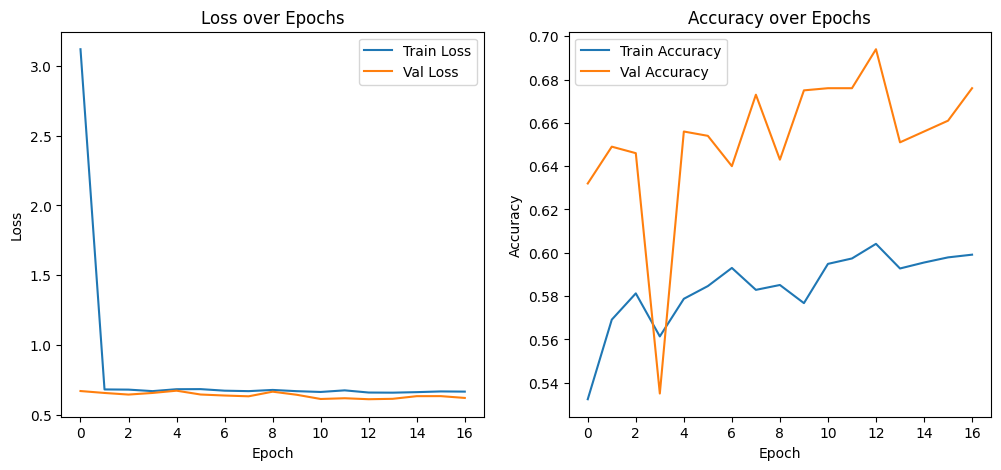

Epoch 17/30
  Train Loss: 0.6677, Train Acc: 0.5991
  Val   Loss: 0.6225, Val   Acc: 0.6760
  Best Val Acc: 0.6940 at Epoch 13
  Learning Rate: 0.001000


Early stopping at epoch 18
History saved to models/run_3/history.json


In [ ]:
model = BNDropout3BlockCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    patience=PATIENCE
)

In [16]:
history_path = "models/run_3/history.json"
print_history(history_path)

| Epoch   |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
|---------|--------------|------------|-------------|-----------|
| 1       |       3.118  |     0.6719 |      0.5324 |     0.632 |
| 2       |       0.6834 |     0.6581 |      0.5691 |     0.649 |
| 3       |       0.682  |     0.6466 |      0.5813 |     0.646 |
| 4       |       0.6713 |     0.6582 |      0.5614 |     0.535 |
| 5       |       0.6849 |     0.6744 |      0.5787 |     0.656 |
| 6       |       0.6856 |     0.647  |      0.5846 |     0.654 |
| 7       |       0.6744 |     0.6398 |      0.593  |     0.64  |
| 8       |       0.6711 |     0.6341 |      0.5829 |     0.673 |
| 9       |       0.6798 |     0.6673 |      0.5851 |     0.643 |
| 10      |       0.6709 |     0.6452 |      0.5767 |     0.675 |
| 11      |       0.6653 |     0.615  |      0.5949 |     0.676 |
| 12      |       0.6768 |     0.6204 |      0.5974 |     0.676 |
| 13*     |       0.6612 |     0.6133 |      0.6041 |     0.694 |
| 14      

# Testing

In [4]:
simple_model = Simple3BlockCNN()
simple_model_path = "models/run_1/best_model.pth"
simple_model.load_state_dict(torch.load(simple_model_path))

enhanced_model = BNDropout3BlockCNN()
enhanced_model_path = "models/run_3/best_model.pth"
enhanced_model.load_state_dict(torch.load(enhanced_model_path))

criterion = nn.BCEWithLogitsLoss()

In [ ]:
simple_test = test(model=simple_model,
                   test_loader=test_loader,
                   criterion=criterion)

enhanced_test = test(model=enhanced_model,
                     test_loader=test_loader,
                     criterion=criterion)

In [15]:
from tabulate import tabulate

table_data = [
    ["Simple3BlockCNN", round(simple_test[0], 3), simple_test[1]],
    ["BNDropout3BlockCNN", round(enhanced_test[0], 3), enhanced_test[1]],
]

headers = ["Model", "Loss", "Accuracy"]

print(tabulate(table_data, headers=headers))


Model                 Loss    Accuracy
------------------  ------  ----------
Simple3BlockCNN      1.65        0.689
BNDropout3BlockCNN   0.615       0.683
